In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [34]:
# Load the data
df = pd.read_csv('bank-full.csv', delimiter=';')

In [35]:
# Select required columns
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = df[columns]

In [36]:
# Convert target variable to numeric
df['y'] = (df['y'] == 'yes').astype(int)

In [37]:
# Split the data
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_full_train = df_train.copy()
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [38]:
# Calculate AUC for each numerical variable
numerical_vars = ['balance', 'day', 'duration', 'previous']
auc_scores = {}

In [39]:
for var in numerical_vars:
    auc = roc_auc_score(df_train['y'], df_train[var])
    if auc < 0.5:
        auc = roc_auc_score(df_train['y'], -df_train[var])
    auc_scores[var] = auc

In [40]:
# Find the variable with the highest AUC
highest_auc_var = max(auc_scores, key=auc_scores.get)

In [41]:
highest_auc_var

'duration'

In [42]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [43]:
# Prepare the data
dv = DictVectorizer(sparse=False)

In [44]:
train_dict = df_train.drop('y', axis=1).to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [45]:
val_dict = df_val.drop('y', axis=1).to_dict(orient='records')
X_val = dv.transform(val_dict)

In [46]:
# Train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train['y'])

LogisticRegression(max_iter=1000, solver='liblinear')

In [47]:
# Calculate AUC on validation set
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(df_val['y'], y_pred)
print(f"AUC on validation set: {auc:.3f}")

AUC on validation set: 0.900


In [48]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt


In [49]:
thresholds = np.arange(0, 1, 0.01)
precisions = []
recalls = []


In [50]:
for threshold in thresholds:
    y_pred_binary = (y_pred >= threshold).astype(int)
    precisions.append(precision_score(df_val['y'], y_pred_binary))
    recalls.append(recall_score(df_val['y'], y_pred_binary))

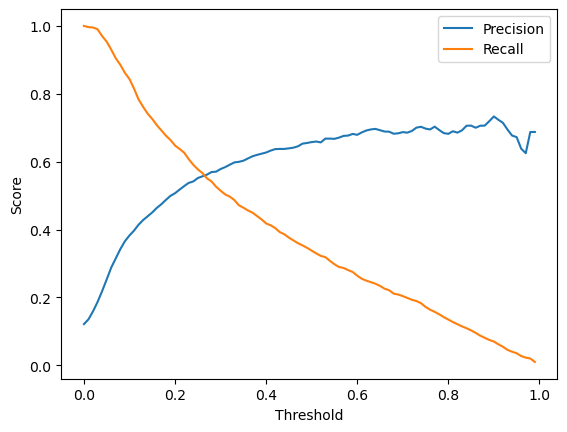

In [51]:
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [52]:
# Find intersection point
intersection_idx = np.argmin(np.abs(np.array(precisions) - np.array(recalls)))
intersection_threshold = thresholds[intersection_idx]
print(f"Precision and recall intersect at threshold: {intersection_threshold:.3f}")

Precision and recall intersect at threshold: 0.260


In [53]:
from sklearn.metrics import f1_score

In [54]:
f1_scores = []

In [55]:
for threshold in thresholds:
    y_pred_binary = (y_pred >= threshold).astype(int)
    f1_scores.append(f1_score(df_val['y'], y_pred_binary))

In [56]:
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
print(f"F1 score is maximal at threshold: {max_f1_threshold:.2f}")

F1 score is maximal at threshold: 0.22


In [57]:
from sklearn.model_selection import KFold

In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

In [59]:
for train_idx, val_idx in kf.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    train_dict = df_train.drop('y', axis=1).to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    val_dict = df_val.drop('y', axis=1).to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, df_train['y'])
    
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(df_val['y'], y_pred)
    scores.append(auc)

std_dev = np.std(scores)
print(f"Standard deviation of scores: {std_dev:.3f}")

Standard deviation of scores: 0.005


In [60]:
C_values = [0.000001, 0.001, 1]
results = []

In [61]:
for C in C_values:
    scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        train_dict = df_train.drop('y', axis=1).to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
        
        val_dict = df_val.drop('y', axis=1).to_dict(orient='records')
        X_val = dv.transform(val_dict)
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, df_train['y'])
        
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(df_val['y'], y_pred)
        scores.append(auc)
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results.append((C, round(mean_score, 3), round(std_score, 3)))

best_result = max(results, key=lambda x: (x[1], -x[2], -x[0]))
print(f"Best C: {best_result[0]}, Mean Score: {best_result[1]}, Std: {best_result[2]}")

Best C: 1, Mean Score: 0.906, Std: 0.005
